In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score
from typing import Any, Union, Callable

In [2]:
df = pd.read_csv('../data/dataset.csv')

In [3]:
df.head()

,usersha1,age,education,gender,name,country,music,artist_name,featured_artists,genre,...,valence,tempo,time_signature,track_genre,release_date,explicit,duration,music_id,id_artists,followers
0,83811,16,Undergraduate,Male,Danielle,Urban,Bank Account,21 Savage,"Birdy, Zoé",Dark Trap,...,0.198838,147.482666,5,Unknown,2017-09-23,True,3.67,2fQrGHiQOvpL9UgPvtYy6G,spotify:artist:1URnnhqYAYcrqrcwql10ft,440898
1,83811,16,Undergraduate,Male,Danielle,Urban,Mo Money Mo Problems (feat. Mase & Puff Daddy)...,The Notorious B.I.G.,LUDMILLA,Underground Rap,...,0.904000,104.536000,4,hardcore,1997-03-04,False,4.29,4INDiWSKvqSKDEu7mh8HFz,spotify:artist:5me0Irg2ANcsgc93uaYrpb,849749
2,83811,16,Undergraduate,Male,Danielle,Urban,Little Talks,Of Monsters and Men,"Ninho, Snoop Dogg, Russ, Paramore",NaN,...,0.417000,102.961000,4,folk,2012-01-01,True,4.44,2ihCaVdNZmnHZWt0fvAM7B,spotify:artist:4dwdTW1Lfiq0cM8nBAqIIz,733052
3,13397,17,Middle School,Female,Angel,Non-Urban,Wherever I Go,OneRepublic,"Keith Urban, DJ Khaled, NIKI, MF DOOM",NaN,...,0.349000,99.961000,4,piano,2016-12-02,True,2.83,46jLy47W8rkf8rEX04gMKB,spotify:artist:5Pwc4xIPtQLFEnJriah9YJ,766179
4,13397,17,Middle School,Female,Angel,Non-Urban,Hands To Myself,Selena Gomez,"SAINt JHN, David Bisbal, will.i.am",NaN,...,0.079792,84.918633,3,Unknown,2015-10-09,True,3.34,3CJvmtWw2bJsudbAC5uCQk,spotify:artist:0C8ZW7ezQVs4URX5aX7Kqx,399591


In [4]:
print(df.shape) # prints the dimensions of the DataFrame

missing_values = np.where(df.isnull(), 1, 0).sum()
print("\nMissing Values:\n", missing_values)

(35001, 32)

Missing Values:
 23616


In [5]:
# Remove rows containing missing values
df_clean = df.dropna()

# prints the dimensions of the cleaned DataFrame
df_clean.shape


(14025, 32)

In [6]:
df = pd.read_csv('../data/cleaned_data.csv')

In [7]:
duplicate_records = df.duplicated().sum()
print(duplicate_records)


0


In [8]:
df.shape

(14025, 33)

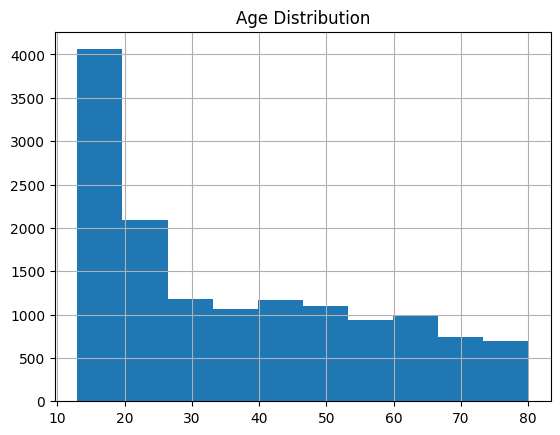

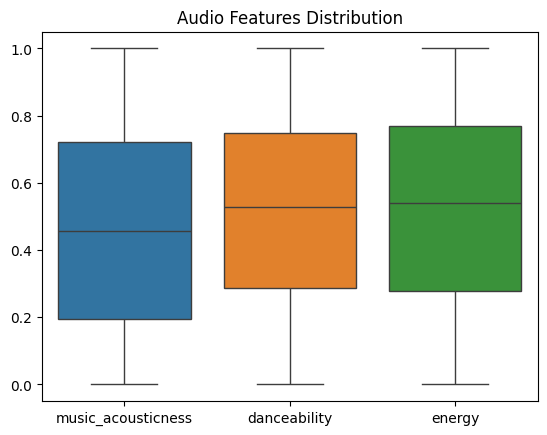

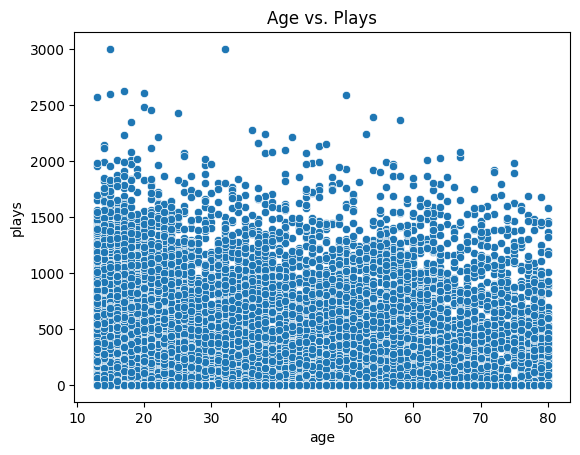

In [9]:
# Summary statistics
summary_stats = df.describe()

# Histograms
df['age'].hist()
plt.title('Age Distribution')
plt.show()

# Box plots for audio features
sns.boxplot(data=df[['music_acousticness', 'danceability', 'energy']])
plt.title('Audio Features Distribution')
plt.show()

# Scatter plots for correlations
sns.scatterplot(x='age', y='plays', data=df)
plt.title('Age vs. Plays')
plt.show()


In [10]:
# AGE GROUPING
# Example: Age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 25, 40, 60, 100], labels=['Teen', 'Young Adult', 'Adult', 'Senior', 'Elderly'])

df['age_group'].unique()

['Teen', 'Senior', 'Adult', 'Elderly', 'Young Adult']
Categories (5, object): ['Teen' < 'Young Adult' < 'Adult' < 'Senior' < 'Elderly']

Average Plays per User

In [11]:
df['avg_plays_per_user'] = df.groupby('usersha1')['plays'].transform('mean')
# df['avg_plays_per_user'].unique()

Aggregrate Popularity Metrics by User Demographics

In [12]:
df['avg_artiste_popularity'] = df.groupby(['age_group', 'gender'])['artiste_popularity'].transform('mean')
df['avg_audio_popularity'] = df.groupby(['age_group', 'gender'])['audio_popularity'].transform('mean')


Summary Statistics for Audio Features by User

In [13]:
audio_features = ['music_acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo']
for feature in audio_features:
    df[f'avg_{feature}_by_demo'] = df.groupby(['age_group', 'gender'])[feature].transform('mean')


Temporal Features:
Extracting Year, Month and Day from Release Date

In [14]:
df['release_year'] = pd.to_datetime(df['release_date']).dt.year
df['release_month'] = pd.to_datetime(df['release_date']).dt.month
df['release_day'] = pd.to_datetime(df['release_date']).dt.day


Calculate Song's Age Since Release:

In [15]:
current_year = pd.to_datetime('today').year
df['song_age'] = current_year - df['release_year']


User Preferences:

In [16]:
user_profiles = df.groupby('usersha1')['genre'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
df['user_favorite_genre'] = df['usersha1'].map(user_profiles)


Calculate Diversity of Genres Each User Listens To:

In [17]:
df['user_genre_diversity'] = df.groupby('usersha1')['genre'].transform(lambda x: x.nunique())

Interaction Features:
Capture Interactions Between User Demographics and Song Characteristics:

In [18]:
df['age_genre_interaction'] = df['age'] * df['genre'].apply(lambda x: hash(x) % 100)


Create Features that Measure User Affinity Towards Certain Genres or Artists:

In [19]:
user_genre_affinity = df.groupby(['usersha1', 'genre'])['plays'].sum().unstack().fillna(0)
df['user_genre_affinity'] = df.apply(lambda row: user_genre_affinity.loc[row['usersha1'], row['genre']], axis=1)


Advanced Audio Features:
Create Composite Features from Existing Audio Features:

In [20]:
df['energy_acousticness_ratio'] = df['energy'] / (df['music_acousticness'] + 1e-9)


Verification  checks

In [21]:
# Checking the average plays per user calculation
avg_plays_per_user_check = df.groupby('usersha1')['plays'].mean()
assert df['avg_plays_per_user'].equals(df['usersha1'].map(avg_plays_per_user_check))

# Checking the average artiste popularity by demographics
avg_artiste_popularity_check = df.groupby(['age_group', 'gender'])['artiste_popularity'].mean()
assert df['avg_artiste_popularity'].equals(df[['age_group', 'gender']].apply(lambda row: avg_artiste_popularity_check[row['age_group'], row['gender']], axis=1))

# Checking the average audio popularity by demographics
avg_audio_popularity_check = df.groupby(['age_group', 'gender'])['audio_popularity'].mean()
assert df['avg_audio_popularity'].equals(df[['age_group', 'gender']].apply(lambda row: avg_audio_popularity_check[row['age_group'], row['gender']], axis=1))


In [22]:
for feature in audio_features:
    avg_feature_by_demo_check = df.groupby(['age_group', 'gender'])[feature].mean()
    assert df[f'avg_{feature}_by_demo'].equals(df[['age_group', 'gender']].apply(lambda row: avg_feature_by_demo_check[row['age_group'], row['gender']], axis=1))


In [23]:
df['release_year_check'] = pd.to_datetime(df['release_date']).dt.year
df['release_month_check'] = pd.to_datetime(df['release_date']).dt.month
df['release_day_check'] = pd.to_datetime(df['release_date']).dt.day

assert df['release_year'].equals(df['release_year_check'])
assert df['release_month'].equals(df['release_month_check'])
assert df['release_day'].equals(df['release_day_check'])


In [24]:
df['release_year_check'] = pd.to_datetime(df['release_date']).dt.year
df['release_month_check'] = pd.to_datetime(df['release_date']).dt.month
df['release_day_check'] = pd.to_datetime(df['release_date']).dt.day

assert df['release_year'].equals(df['release_year_check'])
assert df['release_month'].equals(df['release_month_check'])
assert df['release_day'].equals(df['release_day_check'])


In [25]:
df['song_age_check'] = current_year - df['release_year']
assert df['song_age'].equals(df['song_age_check'])


In [26]:
# Adding a feature for season based on release month
df['release_season'] = df['release_month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')


In [27]:
user_profiles_check = df.groupby('usersha1')['genre'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
assert df['user_favorite_genre'].equals(df['usersha1'].map(user_profiles_check))


In [28]:
user_genre_diversity_check = df.groupby('usersha1')['genre'].nunique()
assert df['user_genre_diversity'].equals(df['usersha1'].map(user_genre_diversity_check))


In [29]:
# Checking the interaction term
df['age_genre_interaction_check'] = df['age'] * df['genre'].apply(lambda x: hash(x) % 100)
assert df['age_genre_interaction'].equals(df['age_genre_interaction_check'])


In [30]:
# Checking user genre affinity
df['user_genre_affinity_check'] = df.apply(lambda row: user_genre_affinity.loc[row['usersha1'], row['genre']], axis=1)
assert df['user_genre_affinity'].equals(df['user_genre_affinity_check'])


In [31]:
# Checking the energy_acousticness_ratio calculation
df['energy_acousticness_ratio_check'] = df['energy'] / (df['music_acousticness'] + 1e-9)
assert df['energy_acousticness_ratio'].equals(df['energy_acousticness_ratio_check'])


**Feature Selection**

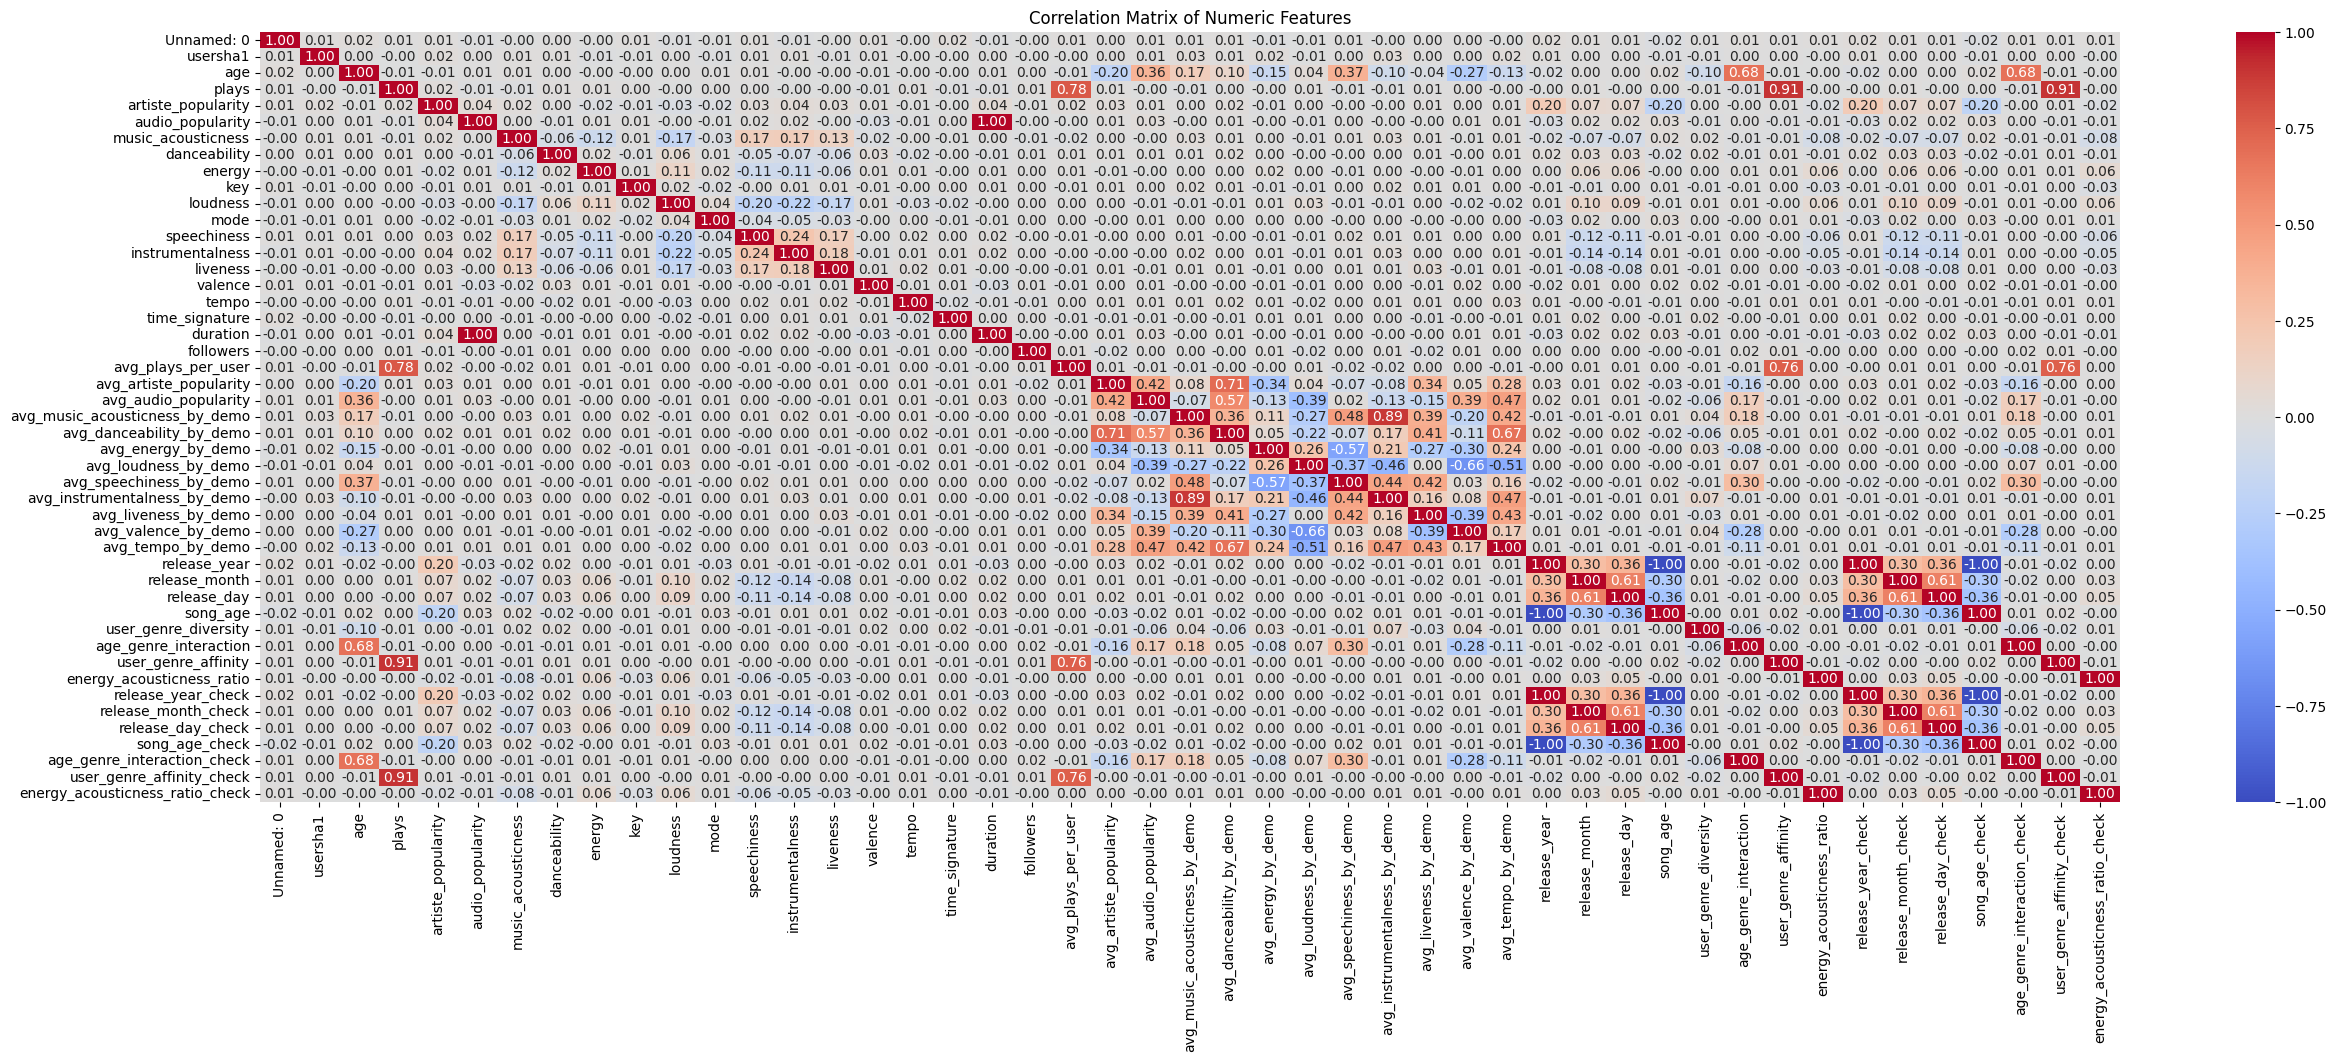

In [32]:
# Assuming df is already loaded and preprocessed
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
correlation_matrix = df[numeric_features].corr()

# Plot the heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [33]:
# Drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'usersha1'], inplace=True)

# Identify features
categorical_features = ['education', 'gender', 'country', 'age_group', 'user_favorite_genre', 'release_season']
numerical_features = df.select_dtypes(include=[float, int]).columns.tolist()

# Remove the target variable from numerical features
numerical_features.remove('plays')  # Assuming 'plays' is the target variable

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the target variable
X = df.drop(columns=['plays'])
y = df['plays']

# Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X)

# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Checking the shape of the preprocessed data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (11220, 96)
Shape of X_test: (2805, 96)
Shape of y_train: (11220,)
Shape of y_test: (2805,)


Top 10 Important features
Feature ranking:
36. feature 35 (0.4518323483355492)
43. feature 42 (0.39687400953352986)
18. feature 17 (0.04628662446221382)
34. feature 33 (0.02105356916968505)
13. feature 12 (0.005171618203459855)
17. feature 16 (0.004758014059563352)
10. feature 9 (0.004670173657562928)
12. feature 11 (0.004537250678493388)
6. feature 5 (0.004052857927425741)
14. feature 13 (0.003825106884715256)
Selected Features:
Int64Index([35, 42, 17, 33, 12, 16, 9, 11, 5, 13], dtype='int64')


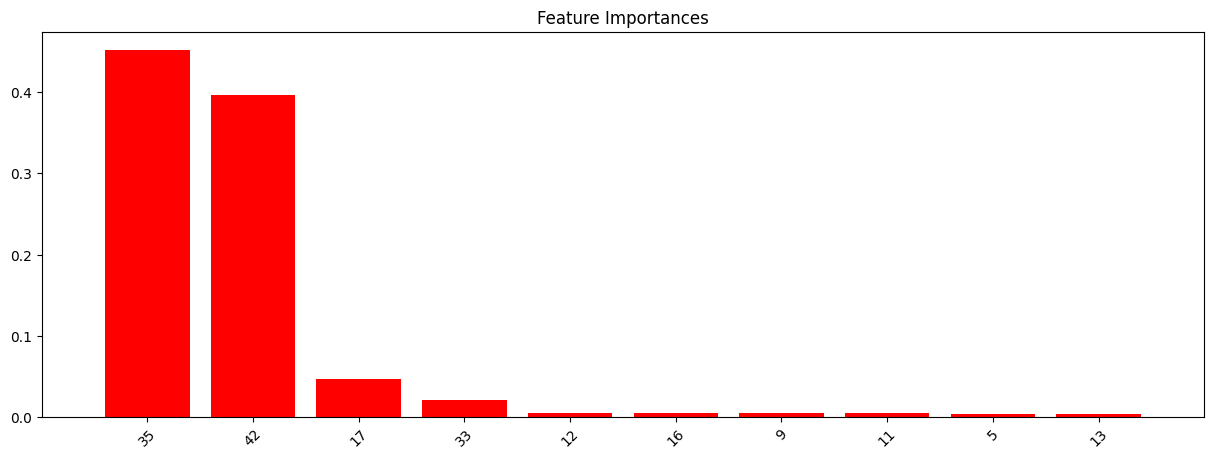

In [34]:
# Keep a copy of the DataFrame for later use
X_train_df = pd.DataFrame(X_train)  # Convert numpy array back to DataFrame if needed

# Fit a RandomForestRegressor to analyze feature importance
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Get the top 10 features
print('Top 10 Important features')
top_10_features = indices[:10]

# Print the feature ranking
print("Feature ranking:")
for f in top_10_features:
    print(f"{f + 1}. feature {X_train_df.columns[f]} ({importances[f]})")

# Use the original DataFrame to get the feature names
selected_features = X_train_df.columns[top_10_features]
print("Selected Features:")
print(selected_features)

# Plot the feature importances
plt.figure(figsize=(15, 5))
plt.title("Feature Importances")
plt.bar(range(10), importances[top_10_features], color="r", align="center")
# Use feature names as x-ticks
plt.xticks(range(10), selected_features, rotation=45)
plt.xlim([-1, 10])
plt.show()


In [35]:
# get me the printed array of items indexed by these from the dataframe 

# Assuming 'df' is your DataFrame
indices = [35, 42, 17, 33, 12, 9, 11, 10, 16, 13]
selected_columns = df.columns[indices]

# Print the names of the selected columns
print(selected_columns)


Index(['avg_music_acousticness_by_demo', 'avg_valence_by_demo', 'mode',
       'avg_artiste_popularity', 'music_acousticness', 'plays',
       'audio_popularity', 'artiste_popularity', 'loudness', 'danceability'],
      dtype='object')


In [36]:
df.shape

(14025, 61)

In [38]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def identify_multicollinearity(df, numerical_features, corr_threshold=0.7, vif_threshold=10):
    """
    Identify multicollinearity in the dataset by calculating the correlation matrix
    and Variance Inflation Factor (VIF).

    Parameters:
    df (DataFrame): The input DataFrame with numerical features.
    numerical_features (list): List of numerical feature names in the DataFrame.
    corr_threshold (float): The threshold for identifying high correlation.
    vif_threshold (float): The threshold for identifying high VIF.

    Returns:
    tuple: A tuple containing sets of highly correlated features and high VIF features.
    """

    # Task 1: Identify Multicollinearity
    correlation_matrix = df[numerical_features].corr()
    highly_correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Task 2: Implement VIF
    vif_data = df[numerical_features]
    vif = pd.DataFrame()
    vif["Features"] = vif_data.columns
    vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    high_vif_features = vif[vif["VIF"] > vif_threshold]["Features"]

    return highly_correlated_features, high_vif_features

# Example usage:
# Assuming 'df' is your DataFrame and 'numerical_features' is your list of numerical feature names
correlated_features, high_vif_features = identify_multicollinearity(df, numerical_features)
print("Highly correlated features:", correlated_features)
print("Features with high VIF (>10):", high_vif_features)


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Highly correlated features: {'song_age', 'song_age_check', 'user_genre_affinity_check', 'release_year_check', 'avg_instrumentalness_by_demo', 'age_genre_interaction_check', 'avg_danceability_by_demo', 'user_genre_affinity', 'energy_acousticness_ratio_check', 'duration', 'release_month_check', 'release_day_check'}
Features with high VIF (>10): 0                                 age
2                    audio_popularity
15                           duration
18             avg_artiste_popularity
19               avg_audio_popularity
20     avg_music_acousticness_by_demo
21           avg_danceability_by_demo
22                 avg_energy_by_demo
23               avg_loudness_by_demo
24            avg_speechiness_by_demo
25       avg_instrumentalness_by_demo
26               avg_liveness_by_demo
27                avg_valence_by_demo
28                  avg_tempo_by_demo
29                       release_year
30                      release_month
31                        release_day
32       

In [39]:
# # Task 1: Identify Multicollinearity

# # Calculate the correlation matrix
# correlation_matrix = df[numerical_features].corr()

# # Identify features with high correlation coefficients (>0.7)
# highly_correlated_features = set()
# for i in range(len(correlation_matrix.columns)):
#     for j in range(i):
#         if abs(correlation_matrix.iloc[i, j]) > 0.7:
#             colname = correlation_matrix.columns[i]
#             highly_correlated_features.add(colname)

# # Print highly correlated features
# print("Highly correlated features:", highly_correlated_features)

# # Task 2: Implement VIF

# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Calculate VIF for each feature
# vif_data = df[numerical_features]
# vif = pd.DataFrame()
# vif["Features"] = vif_data.columns
# vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

# # Print VIF values
# print("\nVIF values:")
# print(vif)

# # Remove features with high VIF values (if necessary)
# high_vif_features = vif[vif["VIF"] > 10]["Features"]
# print("\nFeatures with high VIF (>10):", high_vif_features)

# # # Drop highly correlated and high VIF features from the dataset
# # features_to_drop = highly_correlated_features.union(high_vif_features)
# # df.drop(columns=features_to_drop, inplace=True)


In [40]:
# List of features to drop based on correlation and VIF
features_to_drop = [
    'avg_audio_popularity', 'release_year_check', 'user_genre_affinity_check',
    'duration', 'avg_loudness_by_demo', 'avg_speechiness_by_demo', 
     'age_genre_interaction_check','release_year','release_month',
     'release_day_check','song_age_check',
    'energy_acousticness_ratio_check','avg_music_acousticness_by_demo',
    'avg_danceability_by_demo', 'avg_energy_by_demo','avg_instrumentalness_by_demo',
    'avg_liveness_by_demo', 'avg_valence_by_demo', 'avg_tempo_by_demo','release_month_check', 'release_season'
    
    # Add other highly correlated features identified in the correlation matrix
]
'release_dayrelease_month_check'
# Dropping the selected features
df_reduced = df.drop(columns=features_to_drop)

# Checking the remaining features
print(df_reduced.columns)


Index(['age', 'education', 'gender', 'name', 'country', 'music', 'artist_name',
       'featured_artists', 'genre', 'plays', 'artiste_popularity',
       'audio_popularity', 'music_acousticness', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'track_genre',
       'release_date', 'explicit', 'music_id', 'id_artists', 'followers',
       'age_group', 'avg_plays_per_user', 'avg_artiste_popularity',
       'release_day', 'song_age', 'user_favorite_genre',
       'user_genre_diversity', 'age_genre_interaction', 'user_genre_affinity',
       'energy_acousticness_ratio', 'release_month_check', 'release_season'],
      dtype='object')


In [41]:
df_reduced.shape

(14025, 42)

C:\Users\jnopa\AppData\Local\Temp\ipykernel_11308\3307894794.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_reduced.corr()


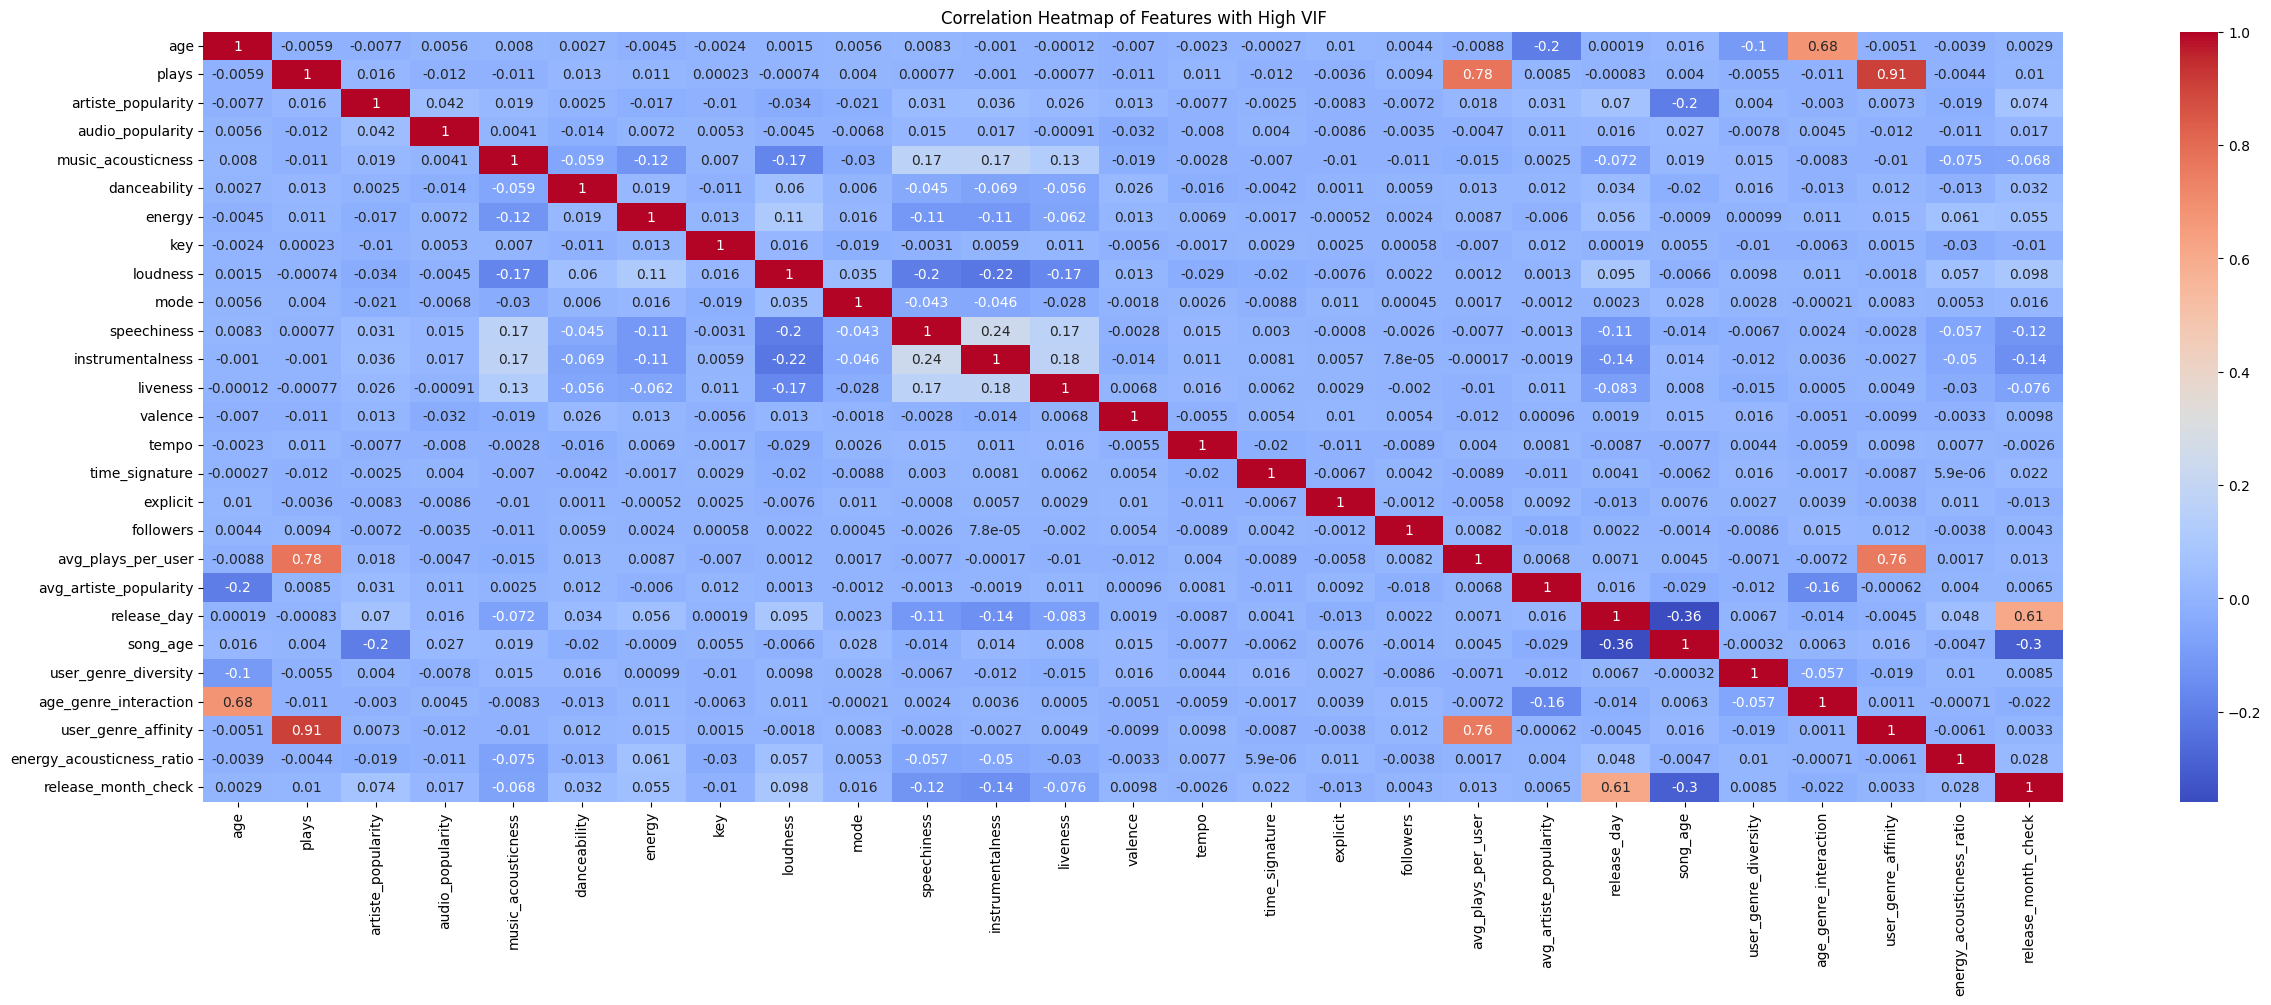

In [42]:
# Create a correlation matrix
corr_matrix = df_reduced.corr()

# Plot the correlation heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features with High VIF')
plt.show()

In [47]:
# Retaining important features
important_features = [
    'age_group','education','country','music','artist_name',
    'featured_artists', 'avg_plays_per_user', 'song_age', 'user_favorite_genre',
    'user_genre_diversity', 'user_genre_affinity', 'energy_acousticness_ratio'
    # Add any other retained features here after checking their importance
]

df_final = df_reduced[important_features]


In [48]:
df_final

,age_group,education,country,music,artist_name,featured_artists,avg_plays_per_user,song_age,user_favorite_genre,user_genre_diversity,user_genre_affinity,energy_acousticness_ratio
0,Teen,Undergraduate,Urban,Bank Account,21 Savage,"Birdy, Zoé",551.000000,7,Dark Trap,2,11.0,0.128475
1,Teen,Undergraduate,Urban,Mo Money Mo Problems (feat. Mase & Puff Daddy)...,The Notorious B.I.G.,LUDMILLA,551.000000,27,Dark Trap,2,1091.0,69.062495
2,Senior,Graduate,Non-Urban,No New Friends,DJ Khaled,"The xx, LIT killah",230.000000,24,Pop,1,230.0,0.391406
3,Teen,Graduate,Urban,Love Without Tragedy / Mother Mary,Rihanna,"Brett Young, Blueface, Lana Del Rey, Queens of...",905.000000,24,Hip-Hop,1,905.0,4.366730
4,Senior,Middle School,Urban,Roses,The Chainsmokers,"Jonas Blue, Radiohead, Pearl Jam, ABBA",728.000000,24,Jazz,2,1261.0,0.190409
...,...,...,...,...,...,...,...,...,...,...,...,...
14020,Teen,Graduate,Urban,Brown Eyed Girl,Van Morrison,"Morat, Alanis Morissette, James Bay, Luis Fonsi",706.333333,57,Dance/Electronic,3,1.0,3.151351
14021,Teen,High School,Urban,Houses Of The Holy,Led Zeppelin,"Dido, Van Halen, Bazzi, Years & Years, Bibi Bl...",890.000000,49,Dance/Electronic,1,890.0,0.280685
14022,Senior,Graduate,Urban,Take You Down,Chris Brown,Florida Georgia Line,176.000000,24,Rock,1,176.0,1.353299
14023,Elderly,Graduate,Non-Urban,Radioactive,Imagine Dragons,"Boyce Avenue, Dermot Kennedy, Kelly Rowland",1.000000,24,Christian/Gospel,2,1.0,0.916113


In [49]:
# df_final.to_csv('../data/important_features.csv')

In [50]:
df = df_final

In [54]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

# Select relevant features
subset_features = [
    'age_group', 
    'education', 
    'country', 
    'music', 
    'artist_name', 
    'featured_artists', 
    'avg_plays_per_user', 
    'song_age', 
    'user_favorite_genre', 
    'user_genre_diversity', 
    'user_genre_affinity', 
    'energy_acousticness_ratio'
]

# Create a new DataFrame with the selected features
df_subset = df[subset_features]

# Define preprocessing for numeric features
numeric_features = [
    'avg_plays_per_user', 
    'song_age', 
    'user_genre_diversity', 
    'user_genre_affinity', 
    'energy_acousticness_ratio'
]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_features = ['age_group', 'education', 'country', 'user_favorite_genre']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessing for text features
text_features = ['artist_name', 'featured_artists']
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=500)),
    ('svd', TruncatedSVD(n_components=50))  # Reducing dimensions
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('artist_tfidf', text_transformer, 'artist_name'),
        ('featured_artists_tfidf', text_transformer, 'featured_artists')
    ])

# Apply preprocessing to features
X = preprocessor.fit_transform(df_subset)

# Encode the target variable 'music'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_subset['music'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the parameter grid to search
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 20),
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)

# Fit the model to the data
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

# Predict using the best estimator
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with Hyperparameter Tuning: {accuracy}')

# Convert predicted labels back to original music titles
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Display a few predictions
print("Sample Predictions with Hyperparameter Tuning:")
for i in range(10):
    print(f"Predicted: {y_pred_labels[i]}, Actual: {label_encoder.inverse_transform([y_test[i]])[0]}")

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
